# @andreanne 

ABIDE TEAM PROJECT ON MACHINE LEARNING

In [156]:
#Import librairies

import os
import pandas as pd
import numpy as np
import prepare_data

import nilearn as nl
from nilearn import plotting as nlp
from nilearn import datasets
from nilearn import image
from nilearn.image import load_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans

In [157]:
output_dir = "/home/anproulx/connectomes_fetched"

In [4]:
# get dataset
abide = datasets.fetch_abide_pcp(pipeline = "cpac",
                                 quality_checked = True)

/home/anproulx/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [62]:
#X, y = prepare_data.prepare_data(data_dir, output_dir) 

In [20]:
def prepare_data(output_dir):
  
    # make list of filenames
    fmri_filenames = abide.func_preproc

    # load atlas
    multiscale = datasets.fetch_atlas_basc_multiscale_2015()
    atlas_filename = multiscale.scale064

    # initialize masker object
    masker = NiftiLabelsMasker(labels_img=atlas_filename,
                               standardize=True,
                               memory='nilearn_cache',
                               verbose=0)

    # initialize correlation measure
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                             discard_diagonal=True)

    try: # check if feature file already exists
        # load features
        feat_file = os.path.join(output_dir, 'ABIDE_BASC064_features.npz')
        X_features = np.load(feat_file)['a']
        print("Feature file found.")

    except: # if not, extract features
        X_features = [] # To contain upper half of matrix as 1d array
        print("No feature file found. Extracting features...")

        for i,sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
            time_series = masker.fit_transform(sub)
            # create a region x region correlation matrix
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # add to our container
            X_features.append(correlation_matrix)
            # keep track of status
            print('finished extracting %s of %s'%(i+1,len(fmri_filenames)))
        # Save features
        np.savez_compressed(os.path.join(output_dir, 'ABIDE_BASC064_features'),
                                         a = X_features)

    # Dimensionality reduction of features with PCA
    print("Running PCA...")
    pca = PCA(0.99).fit(X_features) # keeping 99% of variance
    X_features_pca = pca.transform(X_features)

    # Transform phenotypic data into dataframe
    abide_pheno = pd.DataFrame(abide.phenotypic)

    # Get the target vector
    y_target = abide_pheno['DX_GROUP']

    return X_features_pca, y_target

In [6]:
prepare_data(output_dir)

No feature file found. Extracting features...
finished extracting 1 of 871
finished extracting 2 of 871
finished extracting 3 of 871
finished extracting 4 of 871
finished extracting 5 of 871
finished extracting 6 of 871
finished extracting 7 of 871
finished extracting 8 of 871
finished extracting 9 of 871
finished extracting 10 of 871
finished extracting 11 of 871
finished extracting 12 of 871
finished extracting 13 of 871
finished extracting 14 of 871
finished extracting 15 of 871
finished extracting 16 of 871
finished extracting 17 of 871
finished extracting 18 of 871
finished extracting 19 of 871
finished extracting 20 of 871
finished extracting 21 of 871
finished extracting 22 of 871
finished extracting 23 of 871
finished extracting 24 of 871
finished extracting 25 of 871
finished extracting 26 of 871
finished extracting 27 of 871
finished extracting 28 of 871
finished extracting 29 of 871
finished extracting 30 of 871
finished extracting 31 of 871
finished extracting 32 of 871
fin

(array([[ 5.08201869e+00,  2.54871751e+00,  2.83103836e+00, ...,
          6.32870071e-02,  1.74101107e-02,  1.62016414e-01],
        [ 6.47459751e-01,  1.38423680e+00, -7.93556459e-01, ...,
          1.08540292e-01,  1.07175932e-02, -3.29055886e-02],
        [ 4.71250228e+00, -1.93336238e+00,  5.46511190e-01, ...,
         -6.85600670e-02, -1.26331469e-02, -2.56215257e-02],
        ...,
        [-3.18352284e+00,  2.71231822e+00,  3.44123152e-01, ...,
          5.70292731e-02,  1.29969602e-02,  8.70286300e-02],
        [-7.27850481e+00, -5.88361790e-01, -5.62045946e-01, ...,
          1.14576044e-01, -7.12354516e-02, -3.04468511e-03],
        [ 2.83170858e+00, -2.16417785e+00, -2.35660724e-01, ...,
          2.55865064e-02,  2.80488791e-03,  9.49094507e-02]]),
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 866    1
 867    1
 868    1
 869    1
 870    1
 Name: DX_GROUP, Length: 871, dtype: int64)

In [158]:
feat_file = os.path.join(output_dir, 'ABIDE_BASC064_features.npz')
X_features = np.load(feat_file)['a']

#X_features.shape

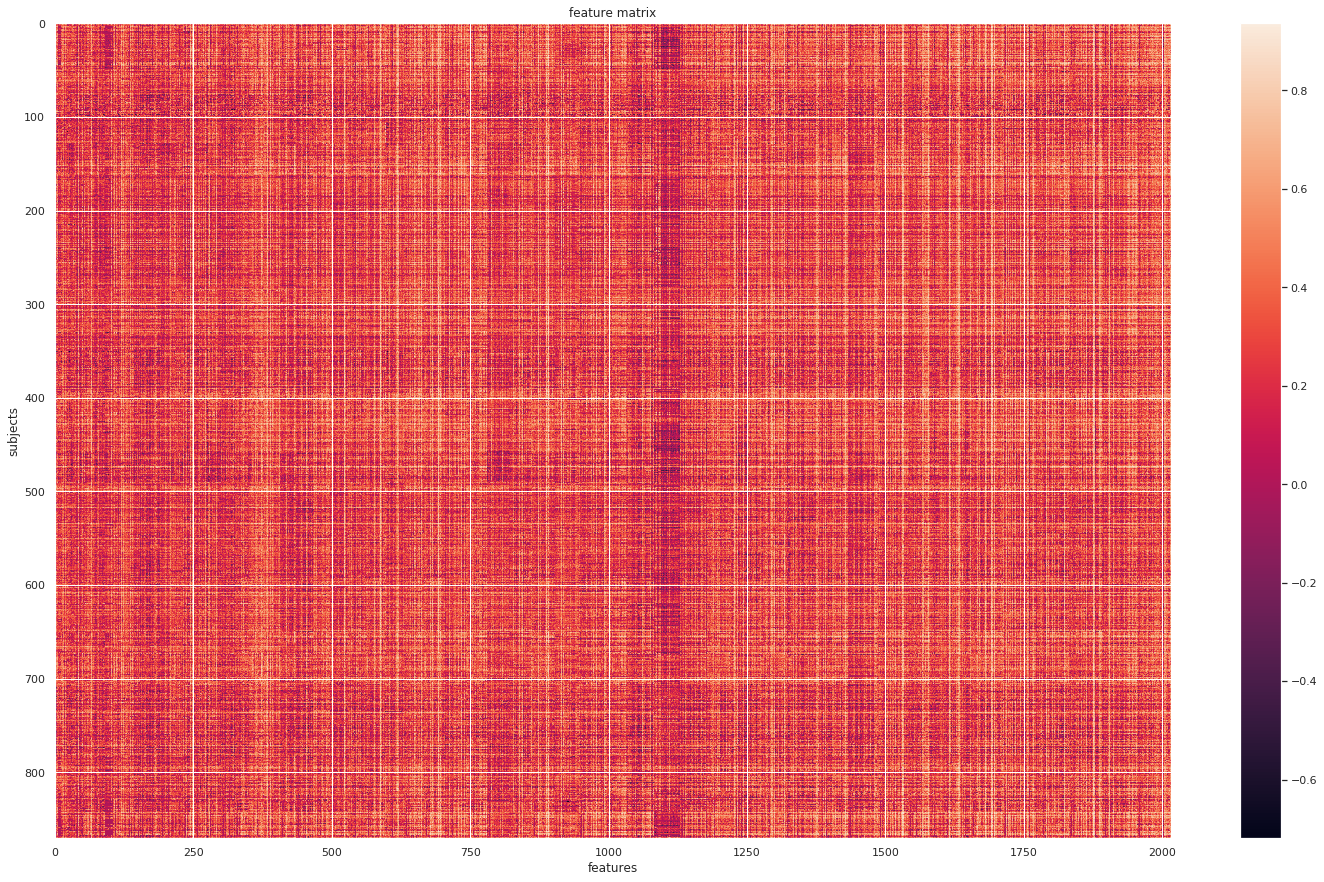

In [159]:
#Plot feature matrix

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)

# Machine learning : classification algorithms

For each estimator:

1. Explore the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values

2. Define a grid range and use SearchGrid to choose the value of multiple hyperparameters simultanously

In [160]:
#Define functions to compute accuracy mean and std 

def compute_acc_std_mean (train_scores, test_scores):
    #train scores
    train_scores_mean= np.mean(train_scores, axis=1)
    train_scores_std= np.std(train_scores, axis=1)
    
    #test scores
    test_scores_mean= np.mean(test_scores, axis=1)
    test_scores_std= np.std(test_scores, axis=1)
    
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

In [161]:
#Define function to plot validation curve

def plot_validationcurve (param, param_range, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std):
    plt.title("Validation Curve")
    plt.xlabel("Hyperparameter : {}".format(param))
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw=2
    #plot train scores
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    #plot test scores
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    
    plt.legend(loc="best")
    plt.gcf().set_size_inches(25, 15)
    
    return plt.show()

In [162]:
# Function returning the best estimator

def best_estimator(model, param_grid, X, y, cv):
    grid = GridSearchCV (model, param_grid, cv=cv)
    grid.fit(X, y)
    model_best= grid.best_estimator_
    param_best= grid.best_params_
    
    return model_best , param_best

In [163]:
#Split the data into training and test set
y_target=abide.phenotypic["DX_GROUP"]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_features, y_target, test_size=0.20, shuffle = True, # shuffle dataset
stratify = y_target)

# Support Vector Machines (SVM)

In [29]:
model_SVC = SVC()

In [75]:
param_range_SVM= np.logspace (-6, 2 , 20)

train_scores_SVM, test_scores_SVM= validation_curve(
    SVC(), X_features, y_target, param_name="gamma", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [77]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_SVM, test_scores_SVM)

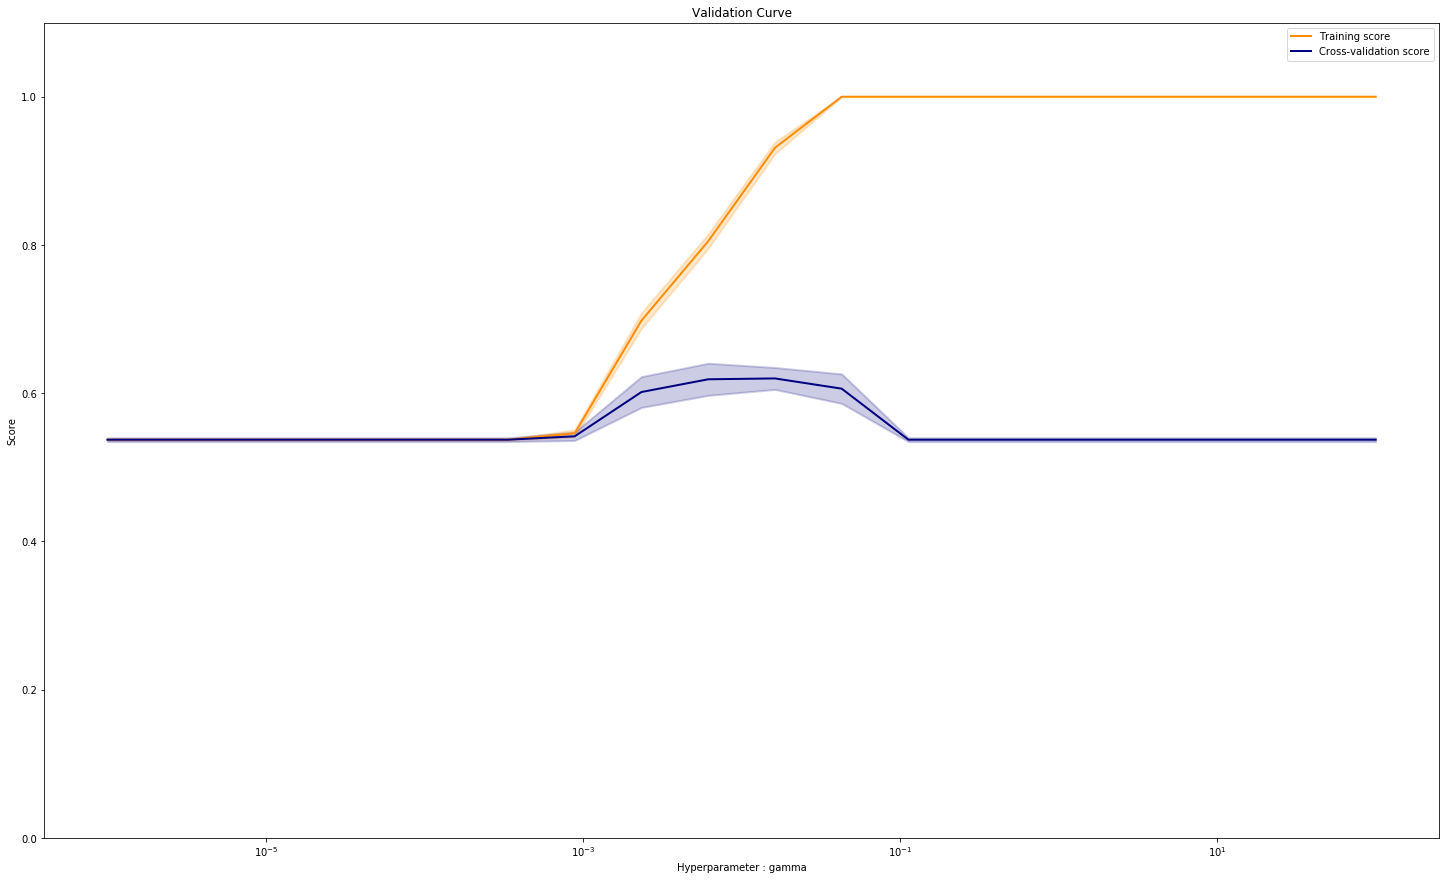

In [78]:
plot_validationcurve("gamma", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [79]:
train_scores_C, test_scores_C= validation_curve(
    SVC(), X_features, y_target, param_name="C", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [82]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_C, test_scores_C)

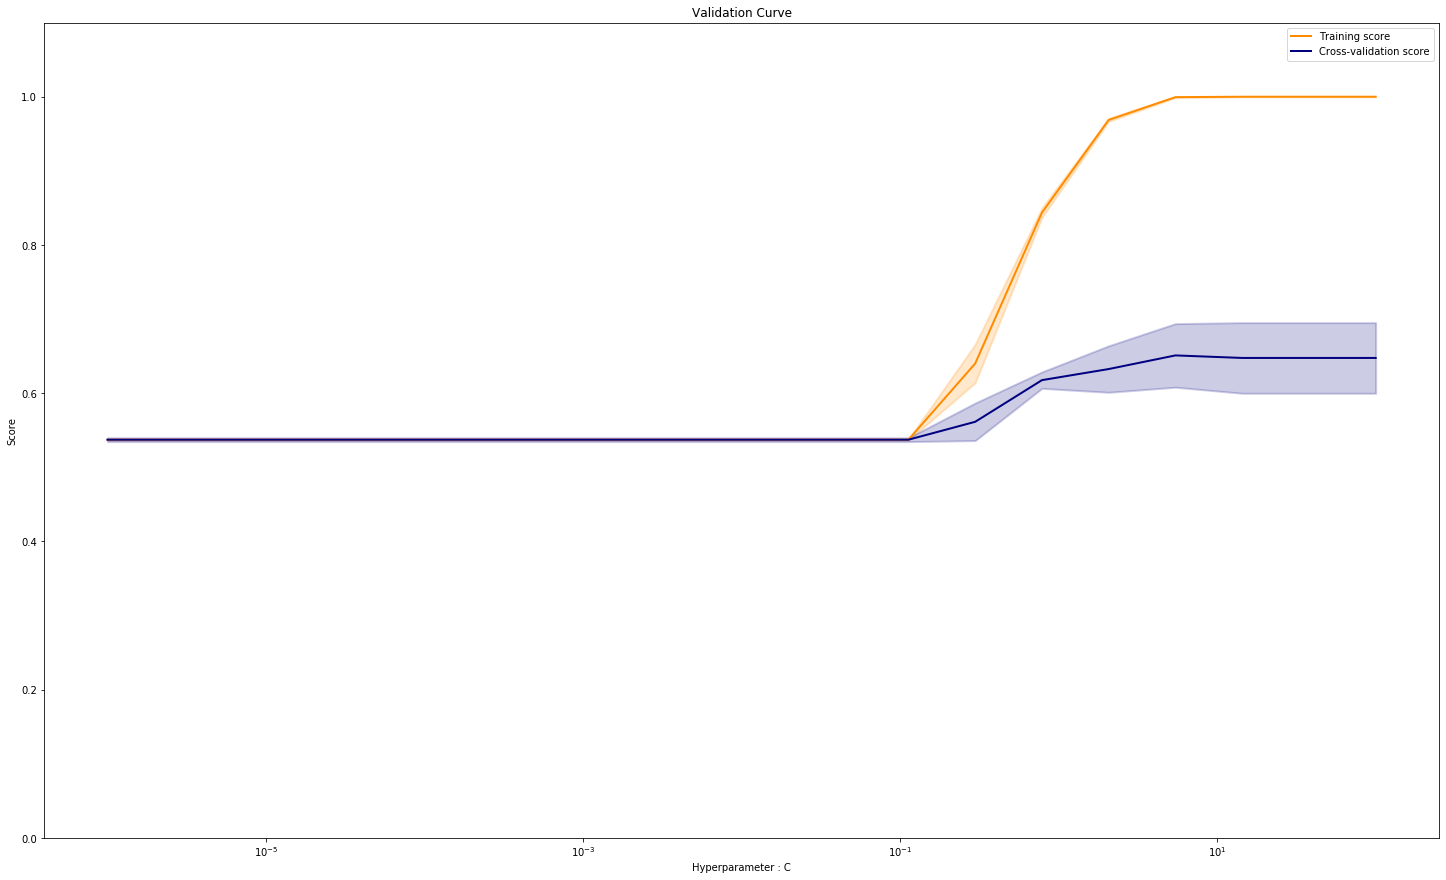

In [86]:
plot_validationcurve("C", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [88]:
#model.get_params().keys()

param_grid_SVC = {'C': [0.01, 0.1, 1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4,  5, 10],
              'gamma': [0.00001, 0.00005,  0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 3.5, 5, 10]}

best_estimator(model_SVC, param_grid_SVC, X_features, y_target, 10)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
model_best = SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

k-fold cross validation

In [96]:
score_kfold=cross_val_score(model_best, X_features, y_target, cv=10).mean() #cv is the number of folds
print(score_kfold)

0.6762016718913271


Leave-one out cross validation

In [98]:
score_leave_one_out= cross_val_score(model_best, X_features, y_target, cv=LeaveOneOut()).mean()
print(score_leave_one_out)

0.6923076923076923


In [102]:
svm_scores= [score_kfold, score_leave_one_out]

In [103]:
#create dataframe to store accuracy scores

classification_accuracy=pd.DataFrame()
classification_accuracy["SVM"]= svm_scores
classification_accuracy.set_axis(['KFold', 'LeaveOneOut'], axis='index')

,SVM
KFold,0.676202
LeaveOneOut,0.692308


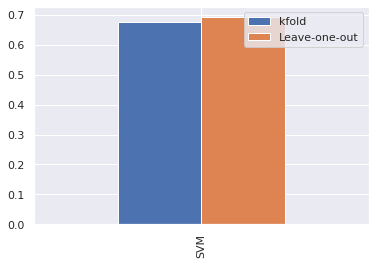

In [126]:
sns.set()
classification_accuracy.T.plot(kind='bar').legend(['kfold', 'Leave-one-out'])


# K Neirest Neighbor (KNN)

In [134]:
param_range_neig = np.arange (1, 50, 1)

In [135]:
train_scores_neig, test_scores_neig = validation_curve(
    KNN(), X_features, y_target, param_name="n_neighbors", param_range=param_range_neig,
    scoring="accuracy", n_jobs=1)

In [136]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_neig, test_scores_neig)

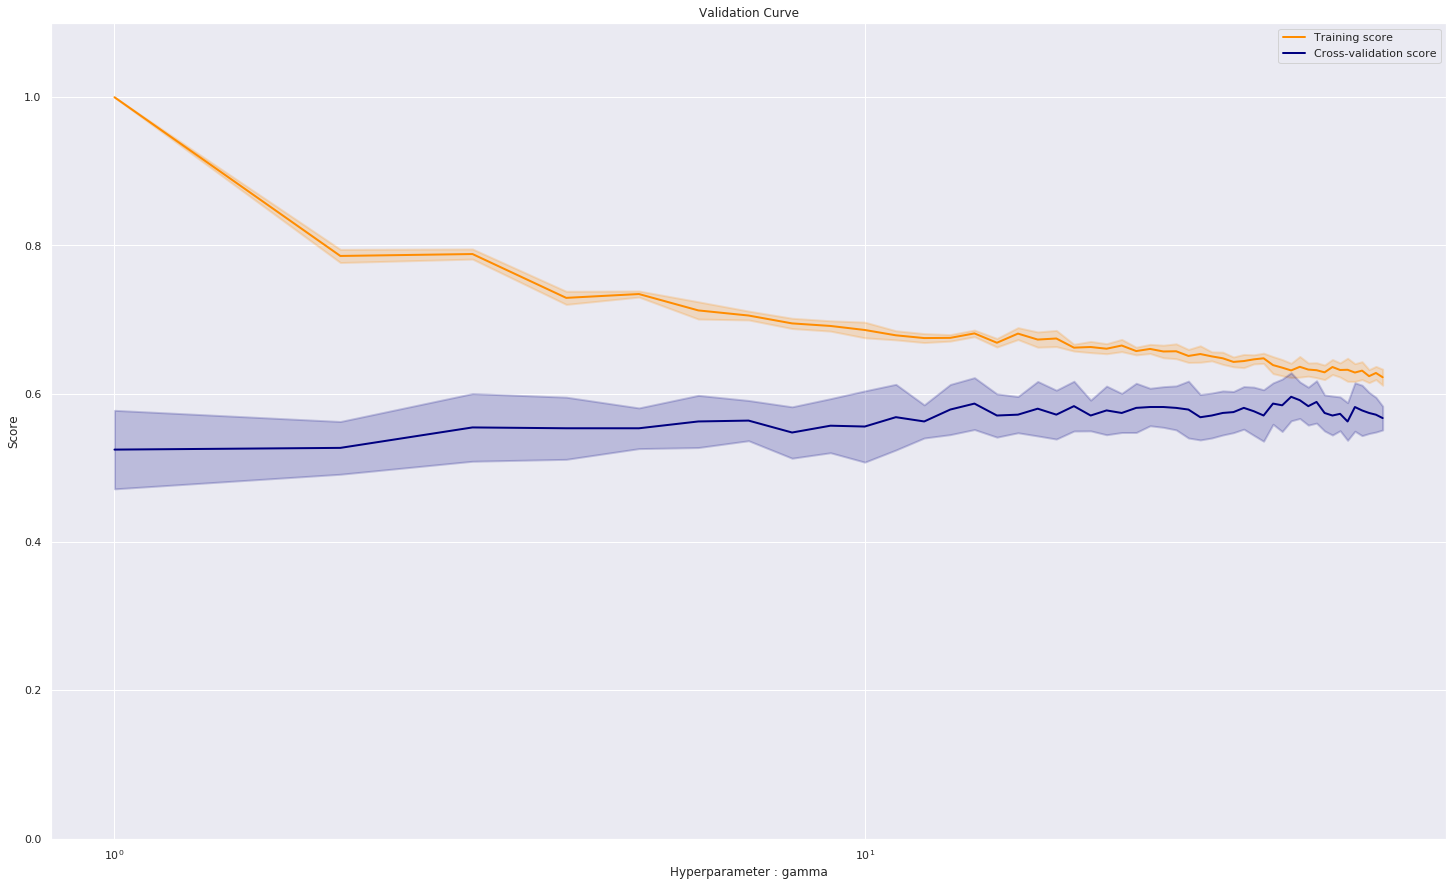

In [137]:
plot_validationcurve("gamma", param_range_neig, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [139]:
model_KNN = KNN()

#model.get_params().keys()

param_grid = {'n_neighbors': [1, 2 , 3, 4, 6, 10, 15, 20, 25, 30, 50, 100],
              #'metric': ["eucledian", "manhattan",  "chebyshev", "minkowski"],
              'algorithm':['auto', 'kd_tree']}

best_estimator(model_KNN, param_grid, X_features, y_target, 10)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [147]:
model_best_KNN=KNN(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

K fold cross validation

In [150]:
score_kfold_knn =cross_val_score(model_best_KNN, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score_kfold_knn)

The accuracy score for 10-folds is :  0.5774164054336468


Leave one out cross validation

In [152]:
score_leave_one_out_knn = cross_val_score(model_best_KNN, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score_leave_one_out_knn)

The accuracy score for leave-one out is:  0.5843857634902411


In [154]:
#add to dataframe 
KNN_scores= [score_kfold_knn, score_leave_one_out_knn]
classification_accuracy["KNN"]= KNN_scores

In [155]:
classification_accuracy

,SVM,KNN
0,0.676202,0.577416
1,0.692308,0.584386


# Decision Tree

In [171]:
param_range_tree = np.arange (1, 11 , 1)

#model_tree = DecisionTreeClassifier()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [175]:
train_scores_tree, test_scores_tree = validation_curve(
    DecisionTreeClassifier(), X_features, y_target, param_name="max_depth", param_range=param_range_tree,
    scoring="accuracy", n_jobs=1)

In [176]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_tree, test_scores_tree)

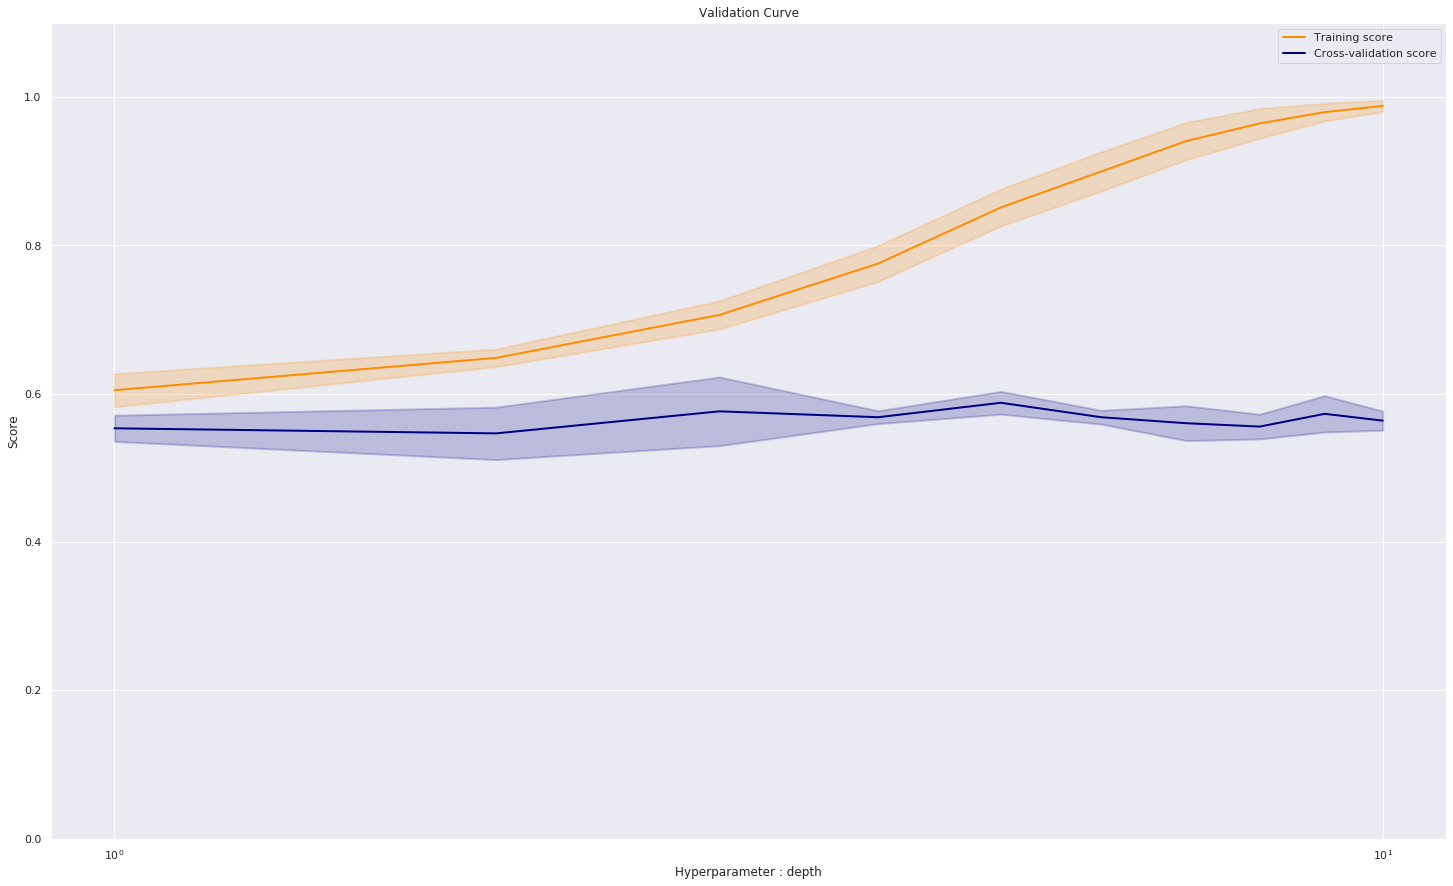

In [177]:
plot_validationcurve("depth", param_range_tree, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

Get the best estimator in regard to depth parameter

In [178]:
#model.get_params().keys()
model_tree = DecisionTreeClassifier()
param_grid = {'max_depth': [1, 2 , 3, 4, 5, 6, 10]}

best_estimator(model_tree, param_grid, X_features, y_target, 10)

(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 {'max_depth': 3})

In [184]:
model_best_tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')
                                        
score_kfold =cross_val_score (model_best_tree, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score_kfold)

The accuracy score for 10-folds is :  0.5589994775339602


In [188]:
score_leave_one_out = cross_val_score (model_best_tree, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score_leave_one_out)

The accuracy score for leave-one out is:  0.669345579793341


# Random forests

Ensemble of decision tree classifiers (bagging)

In [190]:
bag_tree = BaggingClassifier(model_best_tree, n_estimators=100, max_samples=0.8,
random_state=1)

score =cross_val_score (bag_tree, X_features, y_target, cv=10).mean() #cv is the number of folds
print("The accuracy score for 10-folds is : " , score)

The accuracy score for 10-folds is :  0.6246081504702194


In [ ]:
score = cross_val_score (bag_tree, X_features, y_target, cv=LeaveOneOut()).mean()
print("The accuracy score for leave-one out is: ", score)